
# **GOAL:** Starting from ground 0, gain an understanding of the following finance topics

## Options <br>
*** 
* Right but not an **obligation** to buy or sell some financial product at an agreed (Strike/Exercise) price for a given period of time <br>  
    * **Strike Price/Exercise Price**: Pre-determined price at which an option can be traded before the expiry date
        * Technically these are derivatives since the value is derived from underlying asset (i.e. the stock)
    * [Schwab: Options Contracts](https://www.schwab.com/options/options-contracts)

Matplotlib is building the font cache; this may take a moment.


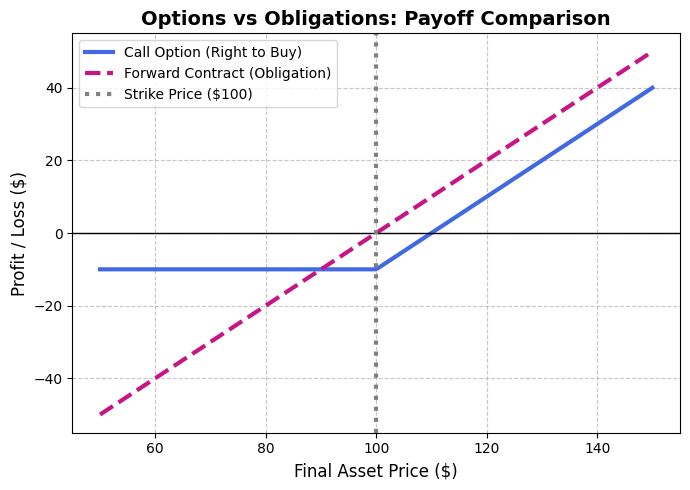

In [ ]:
#installing the necessary packages via uv
!uv pip install yfinance skfolio pandas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skfolio import Portfolio
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit

strike_price = 100  # Strike price for both instruments
spot_prices = np.linspace(50, 150, 200)  # Range of final stock prices
premium = 10  # Option premium paid upfront

option_payoff = np.maximum(spot_prices - strike_price, 0) - premium

forward_payoff = spot_prices - strike_price

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(spot_prices, option_payoff, label='Call Option (Right to Buy)', color='royalblue', linewidth=3)
ax.plot(spot_prices, forward_payoff, label='Forward Contract (Obligation)', color='mediumvioletred', linestyle='--', linewidth=3)

ax.axhline(0, color='black', linewidth=1, linestyle='-')
ax.axvline(strike_price, color='gray', linestyle=':', linewidth=3, label='Strike Price ($100)')

ax.set_title('Options vs Obligations: Payoff Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Final Asset Price ($)', fontsize=12)
ax.set_ylabel('Profit / Loss ($)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=10)


fig.tight_layout()
plt.show()


## What about a Long-Short Arbitrage

In [ ]:
tickers = ['USO', 'XLE']
prices = yf.download(tickers, start='2020-01-01', auto_adjust=True)['Close']
rets = prices.pct_change().dropna()

# Compute spread between normalized prices
norm = prices / prices.iloc[0]
spread = norm['USO'] - norm['XLE']

In [6]:
window = 20
spread_mean = spread.rolling(window).mean()
spread_std = spread.rolling(window).std()
zscore = (spread - spread_mean) / spread_std

# Signals: go long spread when z < -1, short when z > 1
signal = pd.Series(0, index=zscore.index)
signal[zscore < -1] = 1   # long USO, short XLE
signal[zscore > 1]  = -1  # short USO, long XLE
signal = signal.shift().fillna(0)


In [7]:
pos = pd.DataFrame({
    'USO': signal,
    'XLE': -signal
}, index=rets.index)

strat_rets = (pos * rets).sum(axis=1)

In [8]:
# Use z-score features: current and lagged values
X = pd.concat([zscore, zscore.shift(1), zscore.shift(2)], axis=1).dropna()
X.columns = ['z', 'z_lag1', 'z_lag2']
y = (zscore.shift(-1) > zscore.shift(0)).astype(int).loc[X.index]  # predict spread widening

tscv = TimeSeriesSplit(n_splits=5)
clf = LogisticRegression()
clf.fit(X, y)  # simple demonstration—you can grid-search here

ml_signal = clf.predict(X)
ml_pos = pd.DataFrame({
    'USO': ml_signal,
    'XLE': -ml_signal
}, index=X.index)

ml_rets = (ml_pos * rets.loc[X.index]).sum(axis=1)


In [9]:
combined_rets = 0.5 * strat_rets.reindex(ml_rets.index).fillna(0) + 0.5 * ml_rets

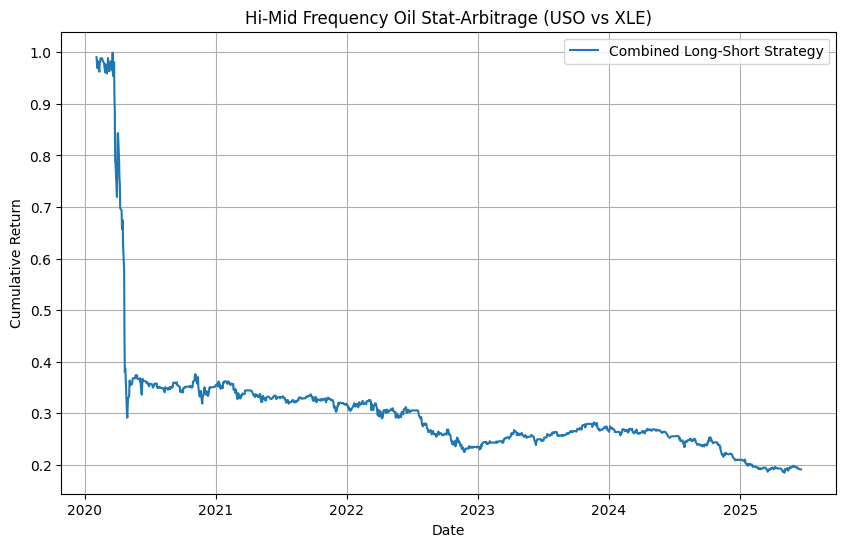

Sharpe Ratio: -0.06805737149588488
Max Drawdown: 1.508446185200077


TypeError: 'numpy.float64' object is not callable

In [10]:
port = Portfolio(X=combined_rets.values.reshape(-1, 1),
                 weights=[1.0])  # all equity in strategy
cum = (1 + pd.Series(port.returns, index=combined_rets.index)).cumprod()

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(cum, label='Combined Long-Short Strategy')
ax.set_title('Hi-Mid Frequency Oil Stat-Arbitrage (USO vs XLE)')
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)
plt.show()

print("Sharpe Ratio:", port.sharpe_ratio)
print("Max Drawdown:", port.max_drawdown)
print("CVaR(95%):", port.cvar(0.95))